workflow simplifier notebook

### Pseudocode
#### Work with one scene for one site
1. Open bands needed for NDVI: red and infrared
    * go into each scene directory and open bands 4 and 3
2. Calculate NDVI for the scene (i.e. scene - set of bands for a particular location).
    * numpy array that contains all NDVI values for all pixels
3. Calculate mean of the NDVI array
    * one mean NDVI value for the scene - stored in mean_NDVI column
4. Parse directory name for site name
5. Parse directory name for the date or Parse file name for an individual band for the date
6. Add site name, date, mean_NDVI to the pandas dataframe
    * add them to a list and then convert that list to a pandas dataframe
        * add values to a list:
            * .append()
            *list_name += [value]
        * add them to individual lists and then concatenate the lists to create the pandas dataframe by converting each list into a column within the pandas dataframe

#### Multiple scenes for one site
* Loop for all directories within the site directory for SJER or HARV

#### Multiple sites
* Loop for all site directories (SJER or HARV)

In [7]:
# Import necessary packages
import os
from glob import glob
import matplotlib.pyplot as plt
from matplotlib import patches as mpatches, colors
import numpy as np
from shapely.geometry import box
import geopandas as gpd
import rasterio as rio
from rasterio.plot import plotting_extent
from rasterio.mask import mask
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
import earthpy.mask as em

# Imports for box function?


# Get data and set working directory
data = et.data.get_data('ndvi-automation')
os.chdir(os.path.join(et.io.HOME, 'earth-analytics'))

In [8]:
# Import SJER site boundary (.shp)
sjer_base_path = os.path.join('data', 'ndvi-automation', 'sites', 'SJER')
sjer_site_boundary_path = os.path.join(
    sjer_base_path, 'vector', 'SJER-crop.shp')
sjer_site_boundary = gpd.read_file(sjer_site_boundary_path, masked=True)

# Import HARV site boundary (.shp)
harv_base_path = os.path.join('data', 'ndvi-automation', 'sites', 'HARV')
harv_site_boundary_path = os.path.join(
    harv_base_path, 'vector', 'HARV-crop.shp')
harv_site_boundary = gpd.read_file(harv_site_boundary_path, masked=True)

In [9]:
# Make a list of directories via glob
path = os.path.join('data','ndvi-automation','*','*','landsat-crop','*')
all_dirs = glob(path)

In [10]:
# qa = glob(os.path.join(all_dirs[0] + '/*pixel_qa*'))
# qa
all_bands = glob(os.path.join(all_dirs[0])+'/*band*.tif')
all_bands.sort()


In [11]:
type(all_bands)

list

Now that we have a list of all the directories the next step is to:
* glob all the files in each directory, extract the qa file, stack the bands to an output tif, import the output tif via context manager, calculate ndvi

In [ ]:
# Automation baby!!!
all_ndvi = []

for directory in all_dirs:
    # Extract the date of the directory 
    date = os.path.basename(os.path.normpath(directory))
    date = date[10:18]
    all_ndvi.append(date)
    
    # Extract qa and open via context manager
    qa_glob = glob(os.path.join(directory + '/*pixel_qa*.tif'))
    with rio.open(qa_glob[0]) as qa_src:
        qa = qa_src.read(1)
    
    # Exctract all_bands(sorted) via glob from each directory
    all_bands_glob = glob(os.path.join(directory + '/*band*.tif'))
    all_bands_glob.sort()
    
    # Run stack function
    output_path = os.path.join('data','ndvi-automation','outputs','file.tif')
    land_stack, land_meta = es.stack(all_bands_glob, output_path)
    
     
    # Open stack ouput .tif and read all_bands via context manager
    with rio.open(output_path) as bands_src:
        all_bands = bands_src.read() # Missing cloud management (come back to this)
                               # Also missing: clipping to the site boundary (come back to this)
    
#     # Mask for cloud cover
#     high_cloud_confidence = em.pixel_flags["pixel_qa"]["L8"]["High Cloud Confidence"]
#     all_bands_free = em.mask_pixels(arr=all_bands, mask_arr=qa, vals=high_cloud_confidence)
    
    
    # Calculate NDVI
    ndvi = es.normalized_diff(all_bands[4], all_bands[3]) 
    
    # Save ndvi's to this list
    all_ndvi.append(ndvi)
    
    
len(all_ndvi) 

Let's complete one workflow with a single directory
* Clip to site boundary
* Handle cloud masking

In [48]:
# Here is the directory we will work with
dir1 = all_dirs[3]

# Here is the masking variable we will use
# Create a list of values that you want to set as "mask" in the pixel qa layer   
high_cloud_confidence = em.pixel_flags["pixel_qa"]["L8"]["High Cloud Confidence"]
cloud = em.pixel_flags["pixel_qa"]["L8"]["Cloud"]
cloud_shadow = em.pixel_flags["pixel_qa"]["L8"]["Cloud Shadow"]

all_masked_values = cloud_shadow + cloud + high_cloud_confidence

# Extract the date of the directory 
date = os.path.basename(os.path.normpath(dir1))
date = date[10:18]
print(date)

# Extract qa and open via context manager
qa_glob = glob(os.path.join(dir1 + '/*pixel_qa*.tif'))
with rio.open(qa_glob[0]) as qa_src:  #### SOMETHING WRONG HERE (why am i indexing 0?)
    qa, qa_meta = es.crop_image(qa_src, sjer_site_boundary)
    #qa = qa_src.read(1)
    qa_extent = plotting_extent(qa_src)
print(qa)

# Exctract all_bands(sorted) via glob from each directory
all_bands_glob = glob(os.path.join(dir1 + '/*band*.tif'))
all_bands_glob.sort()
print(all_bands_glob)

# Run stack function
output_path = os.path.join('data','ndvi-automation','outputs','file.tif')
land_stack, land_meta = es.stack(all_bands_glob, output_path)


# Open stack ouput .tif and read all_bands via context manager
with rio.open(output_path) as bands_src:
    all_bands, all_bands_meta = es.crop_image(bands_src, sjer_site_boundary)
    #all_bands = bands_src.read() # Missing cloud management (come back to this)
                           # Also missing: clipping to the site boundary (come back to this)
# Masking
# Call the earthpy mask function using pixel QA layer
all_bands_masked = em.mask_pixels(arr=all_bands, 
                                     mask_arr =qa, 
                                     vals=all_masked_values)

# Calculate NDVI
ndvi = es.normalized_diff(all_bands_masked[4], all_bands_masked[3]) 
print(ndvi)

# Unmasked NDVI
unmasked_ndvi = es.normalized_diff(all_bands[4], all_bands[3]) 





20171107
[[[322 322 322 ... 322 322 322]
  [322 322 322 ... 322 322 322]
  [322 322 322 ... 322 322 322]
  ...
  [322 322 322 ... 322 322 322]
  [322 322 322 ... 322 322 322]
  [322 322 322 ... 322 322 322]]]
['data/ndvi-automation/sites/SJER/landsat-crop/LC080420342017110701T1-SC20181023170129/LC08_L1TP_042034_20171107_20171121_01_T1_sr_band1.tif', 'data/ndvi-automation/sites/SJER/landsat-crop/LC080420342017110701T1-SC20181023170129/LC08_L1TP_042034_20171107_20171121_01_T1_sr_band2.tif', 'data/ndvi-automation/sites/SJER/landsat-crop/LC080420342017110701T1-SC20181023170129/LC08_L1TP_042034_20171107_20171121_01_T1_sr_band3.tif', 'data/ndvi-automation/sites/SJER/landsat-crop/LC080420342017110701T1-SC20181023170129/LC08_L1TP_042034_20171107_20171121_01_T1_sr_band4.tif', 'data/ndvi-automation/sites/SJER/landsat-crop/LC080420342017110701T1-SC20181023170129/LC08_L1TP_042034_20171107_20171121_01_T1_sr_band5.tif']


ValueError: The values provided for the mask do not occur in your mask array.

In [52]:
ndvi.mean()

masked

In [50]:
unmasked_ndvi.mean()

0.07639474372029915

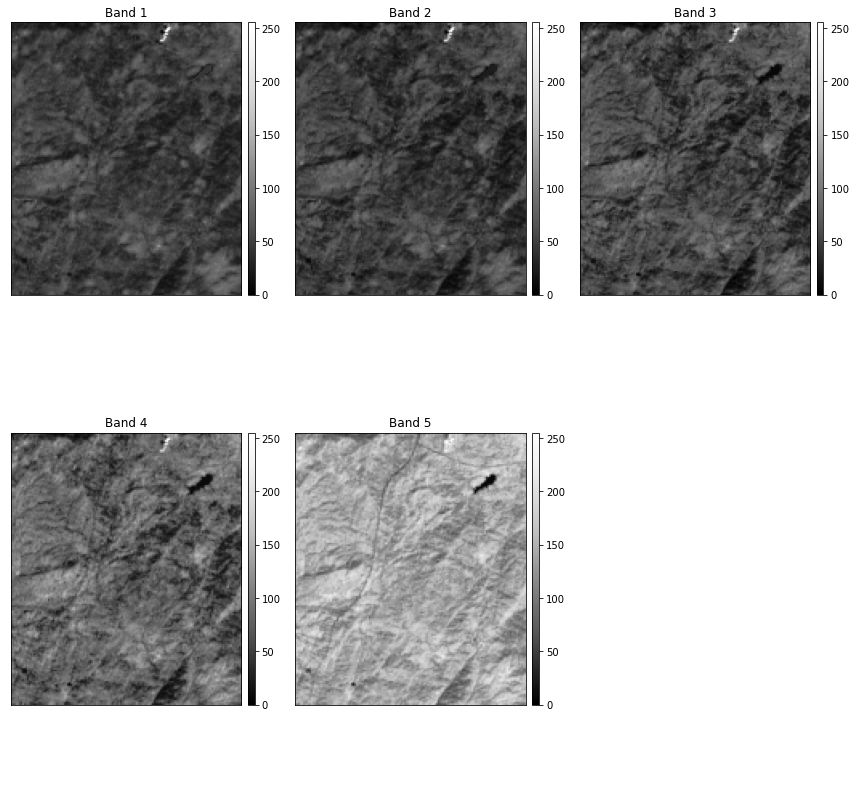

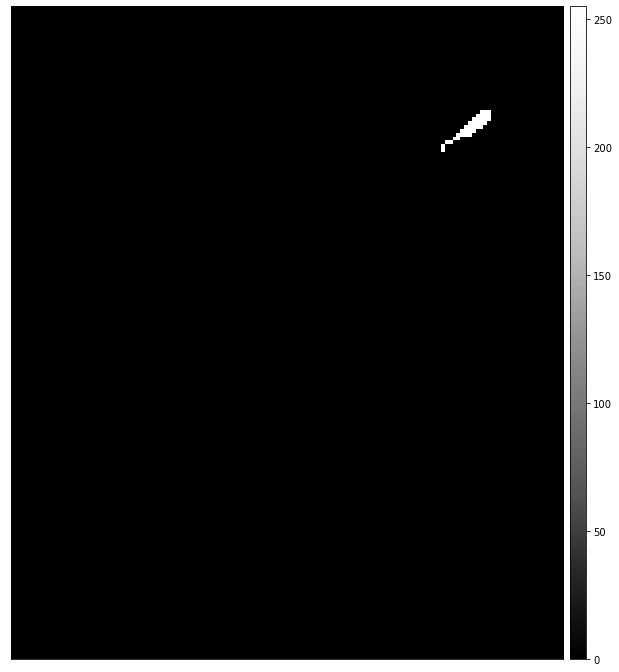

In [51]:
ep.plot_bands(all_bands)
ep.plot_bands(qa)